# Лабораторная работа: Интерполяционные полиномы в структурах и алгоритмах данных



## 1. Введение
Интерполяция — это способ нахождения значения функции в точке по известным значениям в других точках.


## 2. Структуры данных
Изучите классы для хранения узлов и таблицы разделённых разностей.

In [9]:
import numpy as np
import matplotlib.pyplot as plt


class InterpolationNode:
    def __init__(self, x, y):
        self.x = x
        self.y = y


class DividedDifferencesTable:
    def __init__(self, nodes):
        self.n = len(nodes)
        self.x = np.array([node.x for node in nodes])
        self.y = np.array([node.y for node in nodes])
        self.table = self._compute_table()

    def _compute_table(self):
        n = self.n
        F = np.zeros((n, n))
        F[:, 0] = self.y
        for j in range(1, n):
            for i in range(n - j):
                F[i][j] = (F[i + 1][j - 1] - F[i][j - 1]) / (self.x[i + j] - self.x[i])
        return F

    def get_coefs(self):
        return self.table[0, :]


## 3. Реализация полиномов
### Проанализируйте код вычисления полиномов Ньютона/Стирлинга/Лагранжа

Полином Ньютона:

In [10]:
class NewtonPolynomial:
    def __init__(self, nodes):
        self.table = DividedDifferencesTable(nodes)
        self.xnodes = self.table.x
        self.coefs = self.table.get_coefs()
    def evaluate(self, x):
        n = len(self.coefs)
        res = self.coefs[0]
        for i in range(1, n):
            prod = 1
            for j in range(i):
                prod *= (x - self.xnodes[j])
            res += self.coefs[i]*prod
        return res


Полином Стирлинга

In [11]:
from math import factorial
class StirlingPolynomial:
    def __init__(self, nodes):
        self.nodes = sorted(nodes, key=lambda node: node.x)
        self.n = len(nodes)
        self.h = self.nodes[1].x - self.nodes[0].x
        for i in range(self.n-1):
            assert abs(self.nodes[i+1].x - self.nodes[i].x - self.h) < 1e-12, 'Узлы должны быть равноотстоящими'
        assert self.n % 2 == 1, 'Число узлов должно быть нечетным'
        self.m = self.n // 2
        self.x0 = self.nodes[self.m].x
        F = np.zeros((self.n, self.n))
        F[:,0] = np.array([node.y for node in self.nodes])
        for j in range(1, self.n):
            for i in range(self.n-j):
                F[i][j] = F[i+1][j-1] - F[i][j-1]
        self.F = F
    def evaluate(self, x):
        t = (x - self.x0)/self.h
        res = self.F[self.m][0]
        prod = 1
        for k in range(1, self.n):
            prod *= (t - (k-1)//2) if k%2==1 else (t + k//2)
            coeff = self.F[self.m - k//2][k] / factorial(k)
            res += coeff * prod
        return res


Полином Ланграджа

In [12]:
class LagrangePolynomial:
    def __init__(self, nodes):
        self.nodes = nodes
        self.xnodes = [x for x, y in nodes]
        self.ynodes = [y for x, y in nodes]

    def evaluate(self, x):
        res = 0
        n = len(self.nodes)
        for i in range(n):
            term = self.ynodes[i]
            for j in range(n):
                if j != i:
                    term *= (x - self.xnodes[j]) / (self.xnodes[i] - self.xnodes[j])
            res += term
        return res


## 4. Сравнительный анализ методов
Создайте тестовую функцию, которая будет сравнивать ошибки и время выполнения

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from math import pi, sin

def f(x):
    return np.sin(x)


x_nodes = np.linspace(0, pi, 9)
y_nodes = f(x_nodes)
nodes = list(zip(x_nodes, y_nodes))


newton_poly = NewtonPolynomial([type('Node', (), {'x': x, 'y': y}) for x, y in nodes])
stirling_poly = StirlingPolynomial([type('Node', (), {'x': x, 'y': y}) for x, y in nodes])
lagrange_poly = LagrangePolynomial(nodes)


def compare_methods(x_test):
    results = {}
    for name, poly in [('Newton', newton_poly), ('Stirling', stirling_poly), ('Lagrange', lagrange_poly)]:
        start = time.time()
        y_pred = np.array([poly.evaluate(x) for x in x_test])
        end = time.time()
        error = np.max(np.abs(f(x_test) - y_pred))
        results[name] = {'max_error': error, 'time': end - start}
    return results


x_test = np.linspace(0, pi, 10)
results = compare_methods(x_test)
for name, res in results.items():
    print(f"{name}: Max error = {res['max_error']:.3e}, Time = {res['time']:.5f} s")


Newton: Max error = 3.836e-10, Time = 0.01480 s
Stirling: Max error = 6.043e-02, Time = 0.00280 s
Lagrange: Max error = 2.623e-10, Time = 0.04680 s


## 5. Визуализация результатов
Используйте функцию синуса для визуализации результатов. Необходимо вывести узлы, оригинальную функцию и полиномы. Пример:


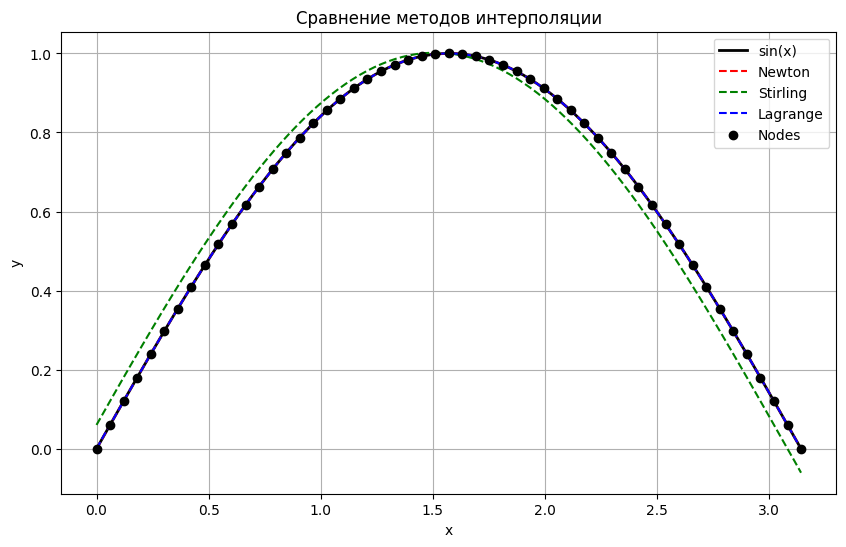

In [43]:
x_plot = np.linspace(0, pi, 100)
y_true = f(x_plot)
y_newton = np.array([newton_poly.evaluate(x) for x in x_plot])
y_stirling = np.array([stirling_poly.evaluate(x) for x in x_plot])
y_lagrange = np.array([lagrange_poly.evaluate(x) for x in x_plot])

plt.figure(figsize=(10,6))
plt.plot(x_plot, y_true, 'k', label='sin(x)', linewidth=2)
plt.plot(x_plot, y_newton, '--r', label='Newton')
plt.plot(x_plot, y_stirling, '--g', label='Stirling')
plt.plot(x_plot, y_lagrange, '--b', label='Lagrange')
plt.scatter(x_nodes, y_nodes, color='black', zorder=5, label='Nodes')
plt.title("Сравнение методов интерполяции")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

## 6. Задания для самостоятельной работы
### 1. Проведите эксперимент с разным числом узлов (5, 7, 9, 11...) и сравните результаты









=== 5 узлов ===
Newton: Max error = 1.812e-03, Time = 0.03245 s
Stirling: Max error = 8.306e-01, Time = 0.01341 s
Lagrange: Max error = 1.812e-03, Time = 0.03627 s


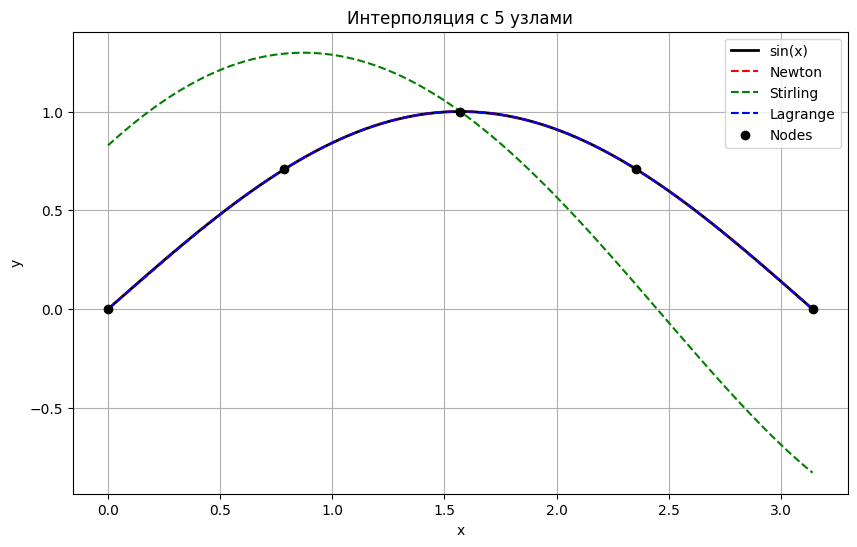


=== 7 узлов ===
Newton: Max error = 3.387e-05, Time = 0.01057 s
Stirling: Max error = 5.359e-01, Time = 0.00823 s
Lagrange: Max error = 3.387e-05, Time = 0.02749 s


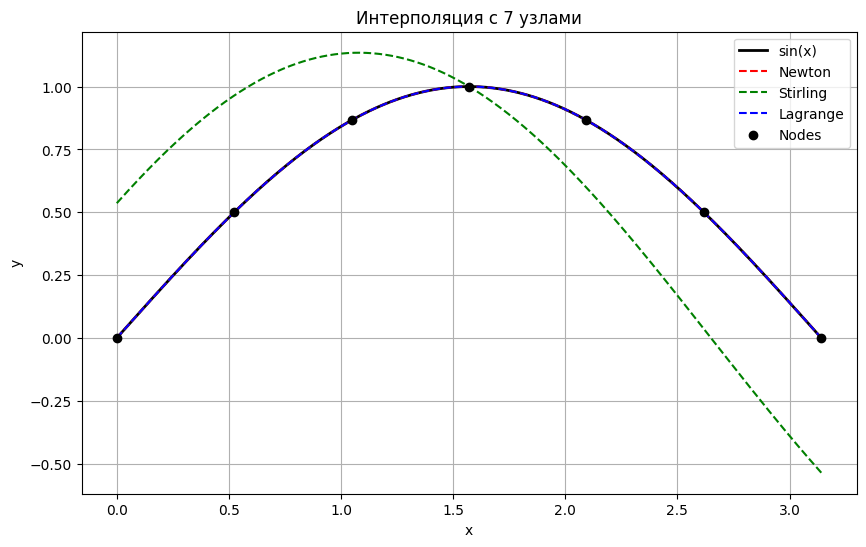


=== 9 узлов ===
Newton: Max error = 4.174e-07, Time = 0.02910 s
Stirling: Max error = 3.978e-01, Time = 0.01792 s
Lagrange: Max error = 4.174e-07, Time = 0.05196 s


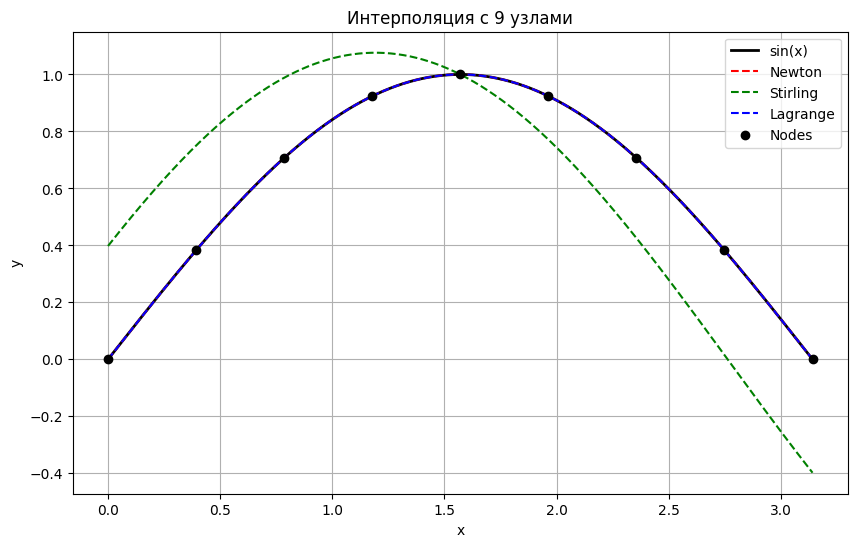


=== 11 узлов ===
Newton: Max error = 3.639e-09, Time = 0.04269 s
Stirling: Max error = 3.168e-01, Time = 0.02262 s
Lagrange: Max error = 3.639e-09, Time = 0.10031 s


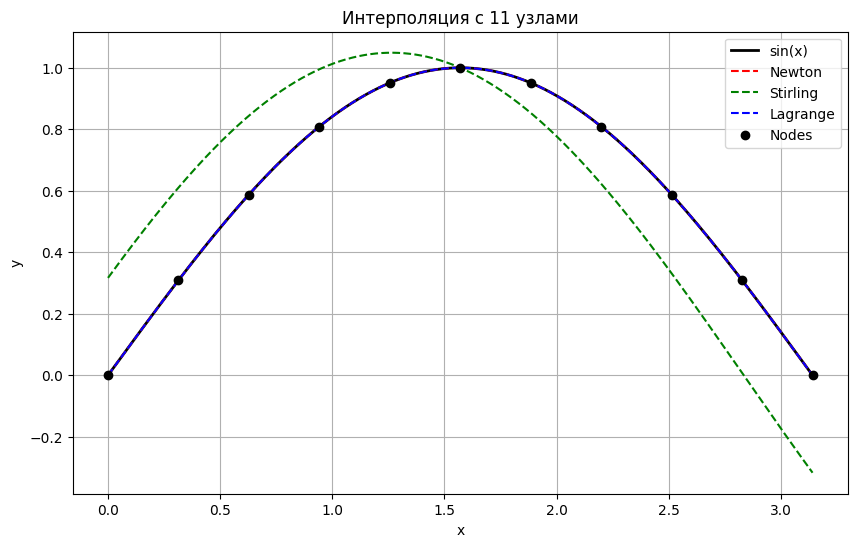

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from math import pi, sin

def f(x):
    return np.sin(x)

def compare_methods(x_test, nodes):
    newton_poly = NewtonPolynomial([type('Node', (), {'x': x, 'y': y}) for x, y in nodes])
    stirling_poly = StirlingPolynomial([type('Node', (), {'x': x, 'y': y}) for x, y in nodes])
    lagrange_poly = LagrangePolynomial(nodes)

    results = {}
    for name, poly in [('Newton', newton_poly), ('Stirling', stirling_poly), ('Lagrange', lagrange_poly)]:
        start = time.time()
        y_pred = np.array([poly.evaluate(x) for x in x_test])
        end = time.time()
        error = np.max(np.abs(f(x_test) - y_pred))
        results[name] = {'max_error': error, 'time': end - start}
    return results

x_test = np.linspace(0, pi, 1000)
node_numbers = [5, 7, 9, 11]

for n in node_numbers:
    print(f"\n=== {n} узлов ===")
    x_nodes = np.linspace(0, pi, n)
    y_nodes = f(x_nodes)
    nodes = list(zip(x_nodes, y_nodes))

    results = compare_methods(x_test, nodes)
    for name, res in results.items():
        print(f"{name}: Max error = {res['max_error']:.3e}, Time = {res['time']:.5f} s")


    newton_poly = NewtonPolynomial([type('Node', (), {'x': x, 'y': y}) for x, y in nodes])
    stirling_poly = StirlingPolynomial([type('Node', (), {'x': x, 'y': y}) for x, y in nodes])
    lagrange_poly = LagrangePolynomial(nodes)

    y_newton = np.array([newton_poly.evaluate(x) for x in x_test])
    y_stirling = np.array([stirling_poly.evaluate(x) for x in x_test])
    y_lagrange = np.array([lagrange_poly.evaluate(x) for x in x_test])

    plt.figure(figsize=(10,6))
    plt.plot(x_test, f(x_test), 'k', label='sin(x)', linewidth=2)
    plt.plot(x_test, y_newton, '--r', label='Newton')
    plt.plot(x_test, y_stirling, '--g', label='Stirling')
    plt.plot(x_test, y_lagrange, '--b', label='Lagrange')
    plt.scatter(x_nodes, y_nodes, color='black', zorder=5, label='Nodes')
    plt.title(f"Интерполяция с {n} узлами")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()


### 2.Протестируйте полиномы на формулах:


$$
\begin{aligned}
&\text{Синус:} \quad f_1(x) = \sin(x), \quad x \in [0, 4\pi] \\
&\text{Косинус:} \quad f_2(x) = \cos(x), \quad x \in [0, 4\pi] \\
&\text{Функция Рунге:} \quad f_3(x) = \frac{1}{1 + 25x^2}, \quad x \in [-1, 1] \\
&\text{Кусочно-линейная (пилообразная):} \quad f_4(x) = x - 5\left\lfloor \frac{x}{5} \right\rfloor, \quad x \in [0, 20] \\
&\text{Функция с быстрыми осцилляциями:} \quad f_5(x) = \sin(10x) e^{-x^2}, \quad x \in [-3, 3]
\end{aligned}
$$



=== Function: sin(x) ===
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
5 nodes: Newton error = 1.000e+00, Stirling error = 1.000e+00, Lagrange error = 1.000e+00


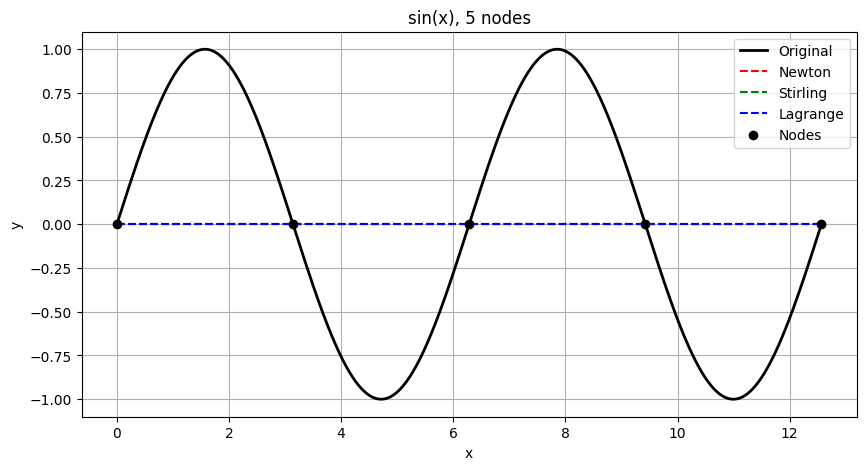

7 nodes: Newton error = 8.136e-01, Stirling error = 8.136e-01, Lagrange error = 8.136e-01


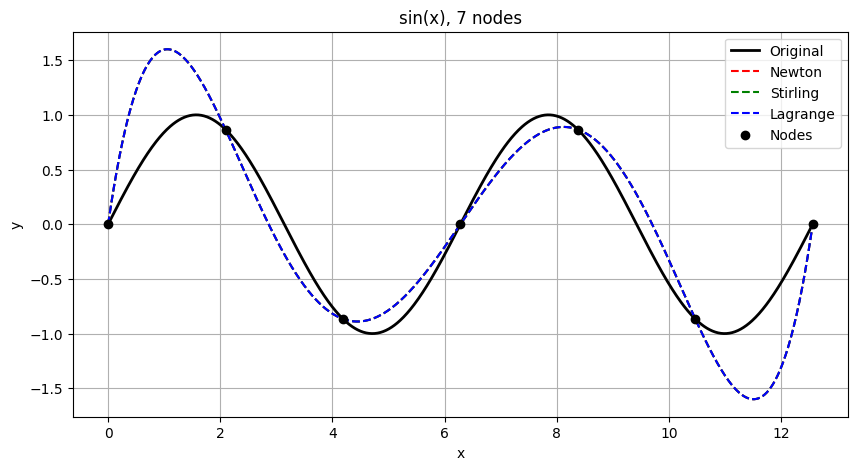

9 nodes: Newton error = 2.821e-01, Stirling error = 2.821e-01, Lagrange error = 2.821e-01


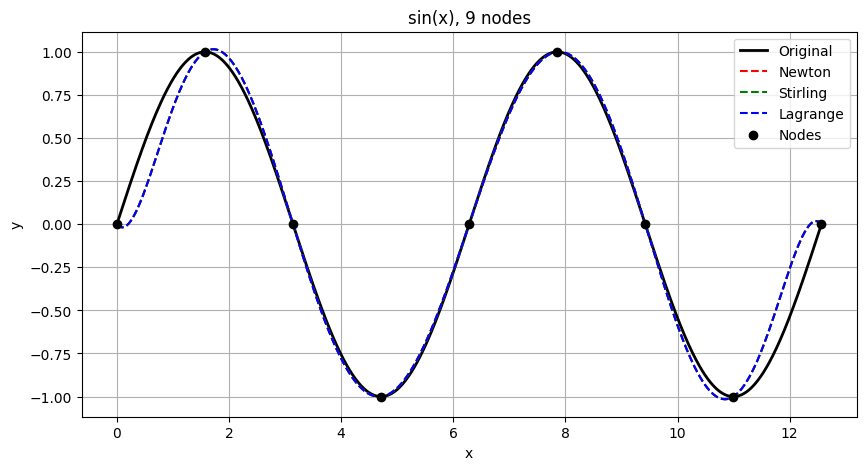

11 nodes: Newton error = 5.753e-02, Stirling error = 5.753e-02, Lagrange error = 5.753e-02


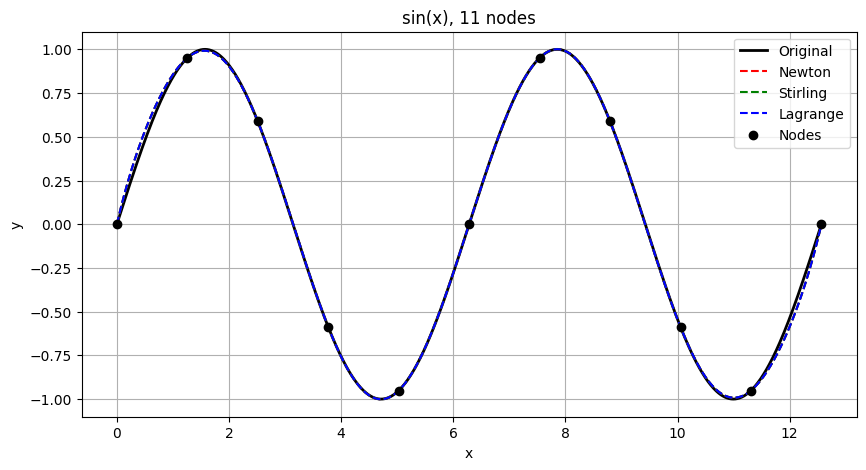

13 nodes: Newton error = 7.918e-03, Stirling error = 7.918e-03, Lagrange error = 7.918e-03


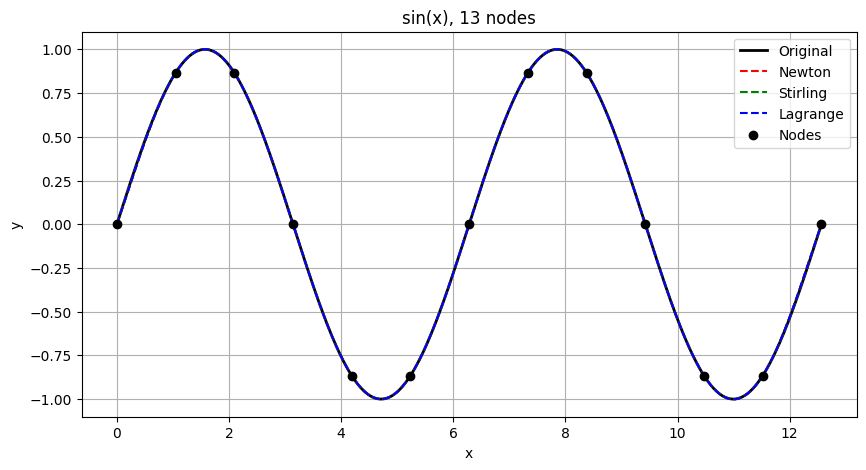


=== Function: cos(x) ===
5 nodes: Newton error = 1.776e+00, Stirling error = 8.000e+00, Lagrange error = 1.776e+00


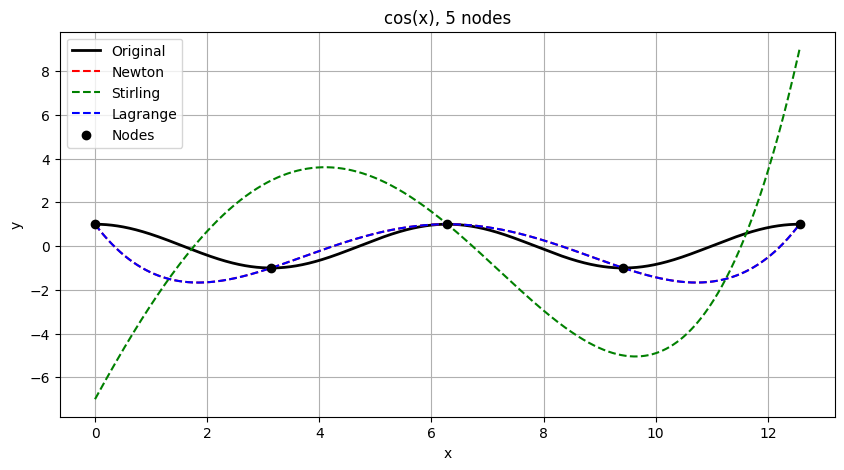

7 nodes: Newton error = 7.952e-01, Stirling error = 6.222e+00, Lagrange error = 7.952e-01


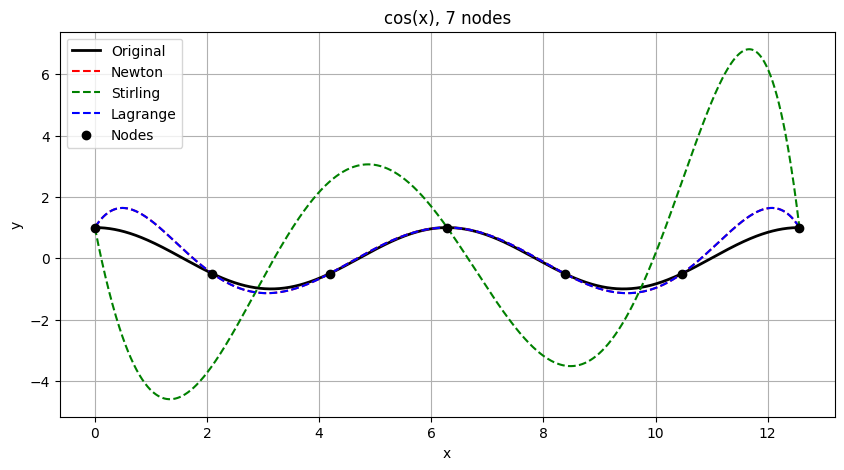

9 nodes: Newton error = 1.982e-01, Stirling error = 2.046e+00, Lagrange error = 1.982e-01


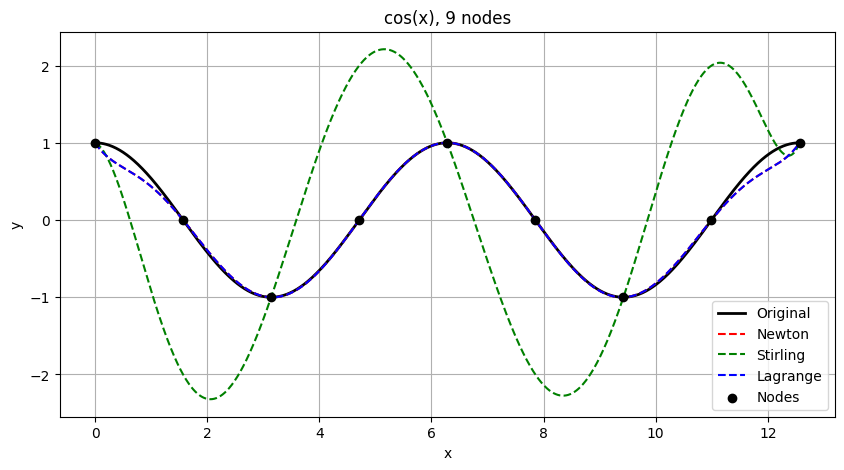

11 nodes: Newton error = 3.214e-02, Stirling error = 1.454e+00, Lagrange error = 3.214e-02


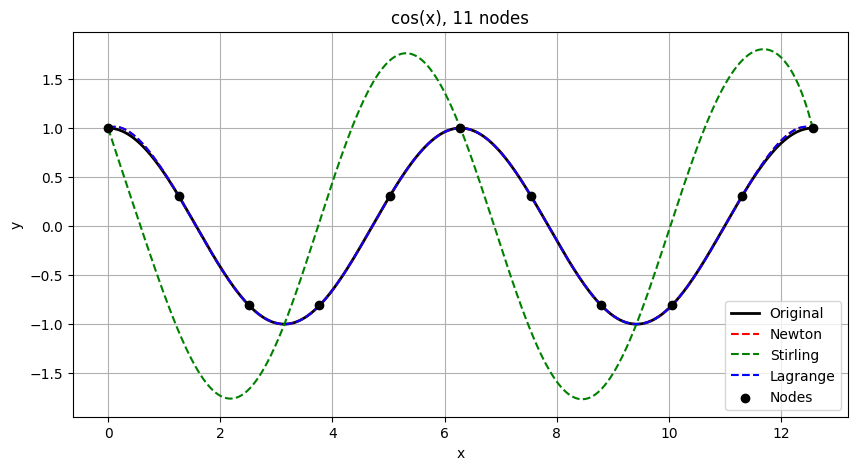

13 nodes: Newton error = 3.699e-03, Stirling error = 1.156e+00, Lagrange error = 3.699e-03


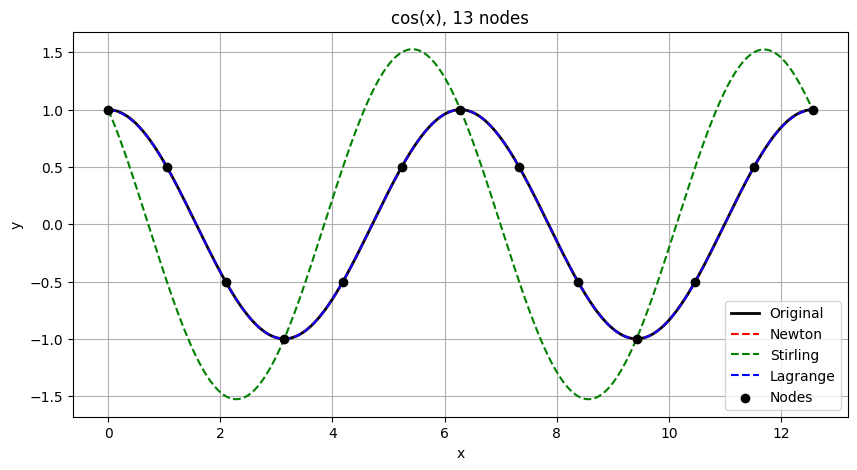


=== Function: Runge ===
5 nodes: Newton error = 4.383e-01, Stirling error = 1.842e+00, Lagrange error = 4.383e-01


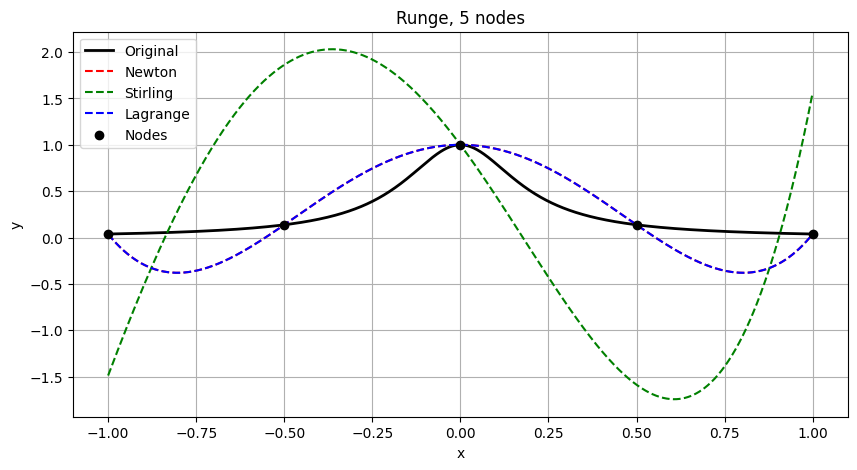

7 nodes: Newton error = 6.169e-01, Stirling error = 2.539e+00, Lagrange error = 6.169e-01


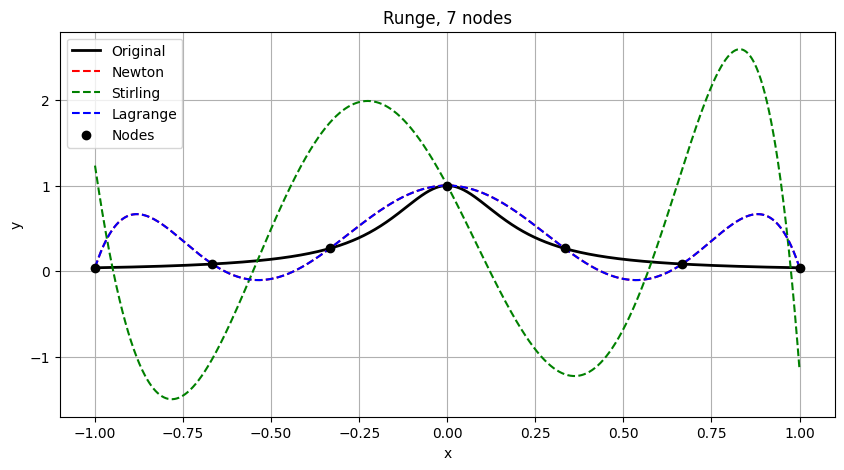

9 nodes: Newton error = 1.045e+00, Stirling error = 4.307e+00, Lagrange error = 1.045e+00


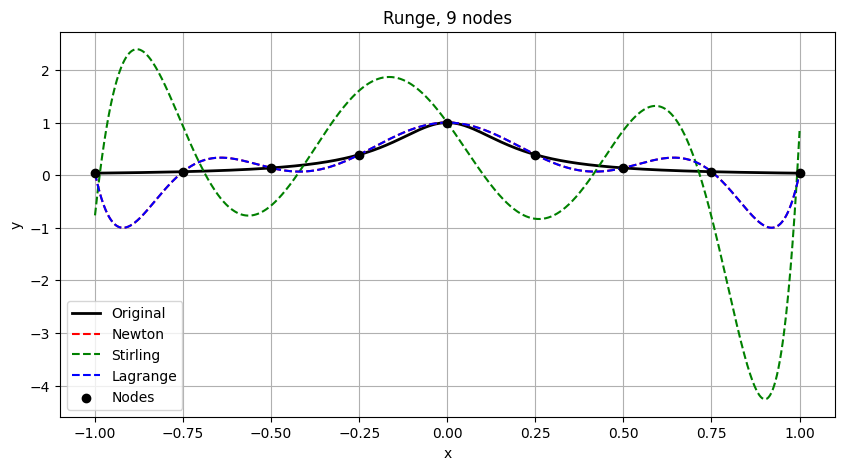

11 nodes: Newton error = 1.916e+00, Stirling error = 7.452e+00, Lagrange error = 1.916e+00


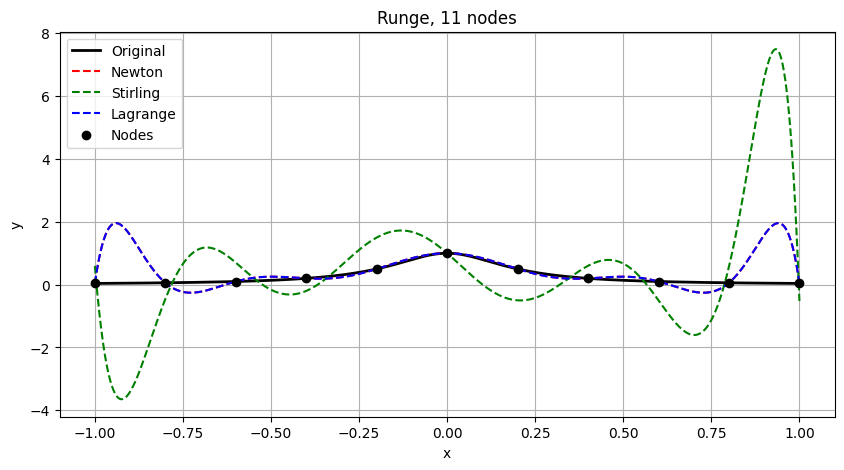

13 nodes: Newton error = 3.663e+00, Stirling error = 1.359e+01, Lagrange error = 3.663e+00


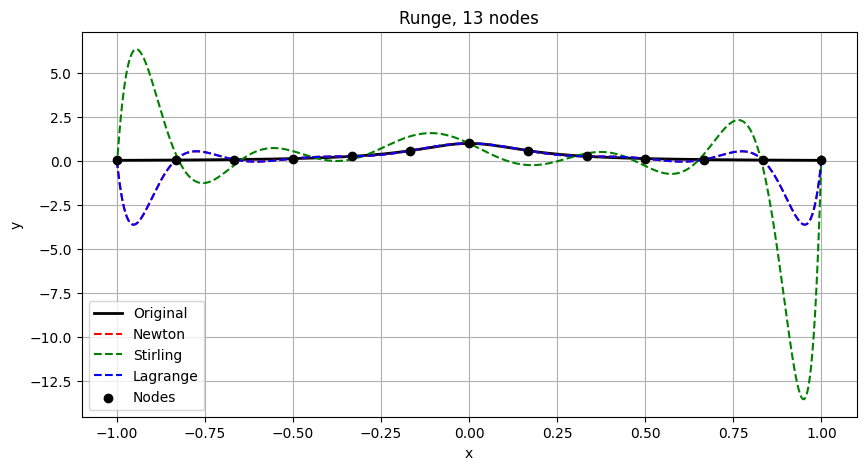


=== Function: Sawtooth ===
5 nodes: Newton error = 4.995e+00, Stirling error = 4.995e+00, Lagrange error = 4.995e+00


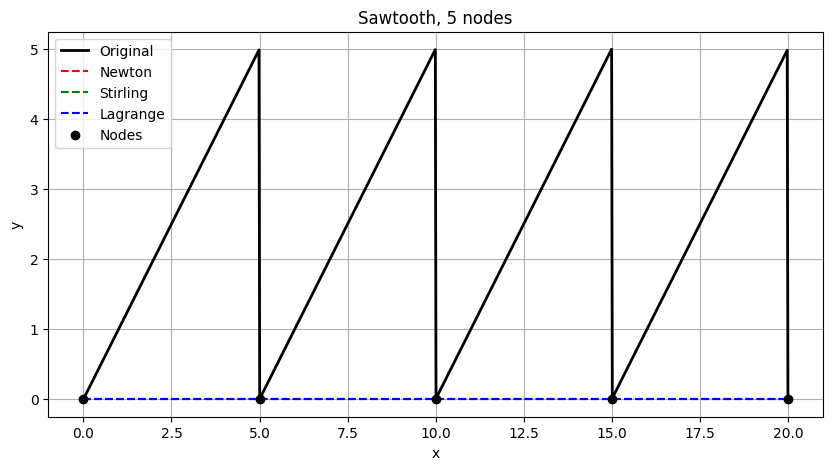

7 nodes: Newton error = 6.448e+00, Stirling error = 1.482e+01, Lagrange error = 6.448e+00


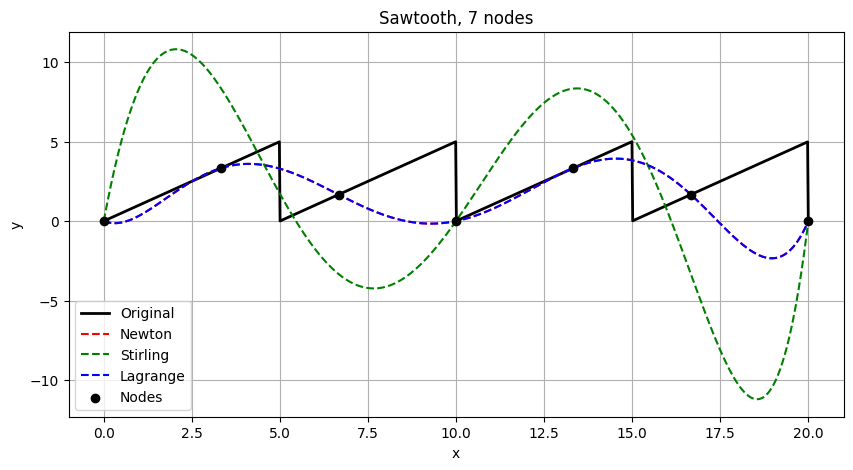

9 nodes: Newton error = 1.319e+01, Stirling error = 4.521e+01, Lagrange error = 1.319e+01


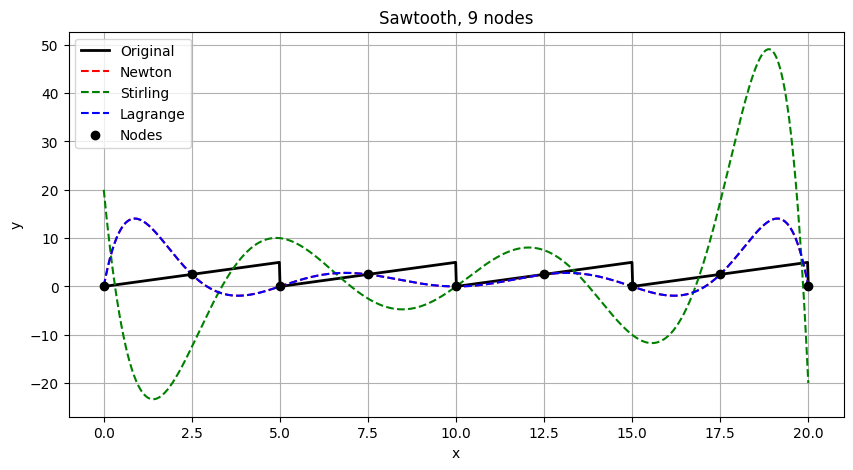

11 nodes: Newton error = 2.441e+01, Stirling error = 5.430e+01, Lagrange error = 2.441e+01


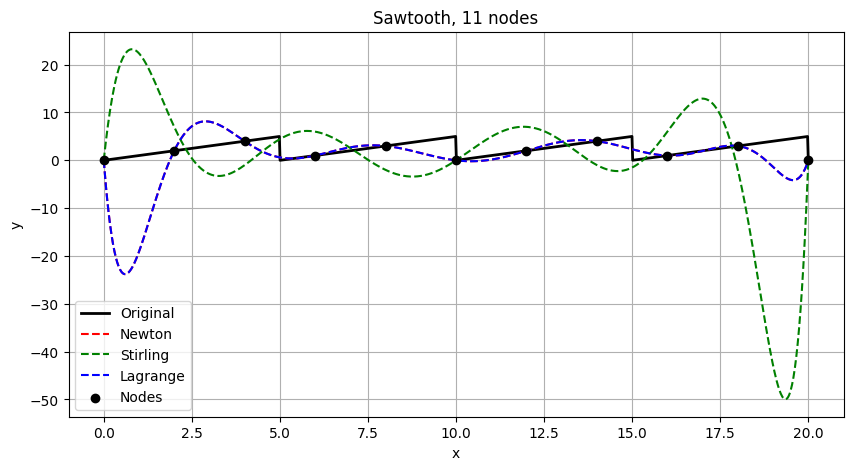

13 nodes: Newton error = 2.275e+01, Stirling error = 4.481e+01, Lagrange error = 2.275e+01


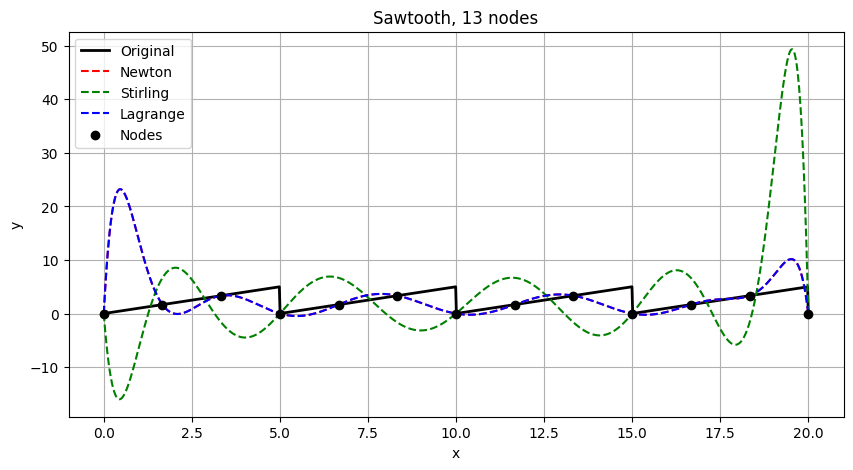


=== Function: Fast oscillation ===
5 nodes: Newton error = 9.668e-01, Stirling error = 9.668e-01, Lagrange error = 9.668e-01


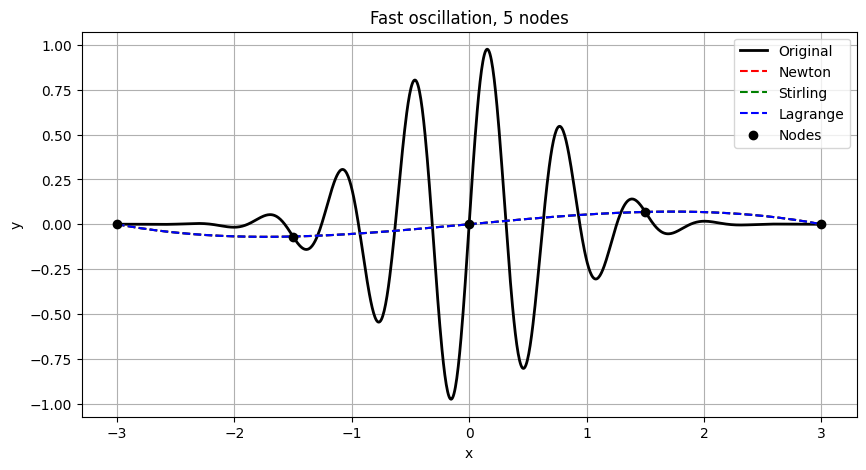

7 nodes: Newton error = 1.023e+00, Stirling error = 1.023e+00, Lagrange error = 1.023e+00


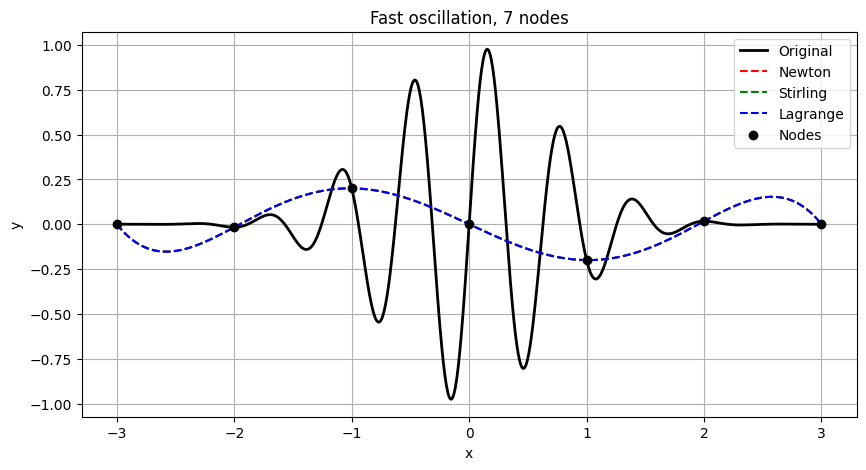

9 nodes: Newton error = 1.243e+00, Stirling error = 1.243e+00, Lagrange error = 1.243e+00


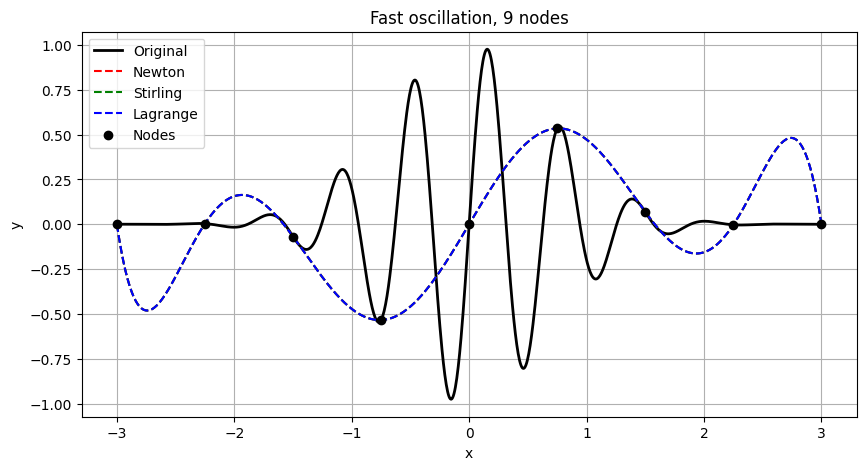

11 nodes: Newton error = 1.044e+00, Stirling error = 1.044e+00, Lagrange error = 1.044e+00


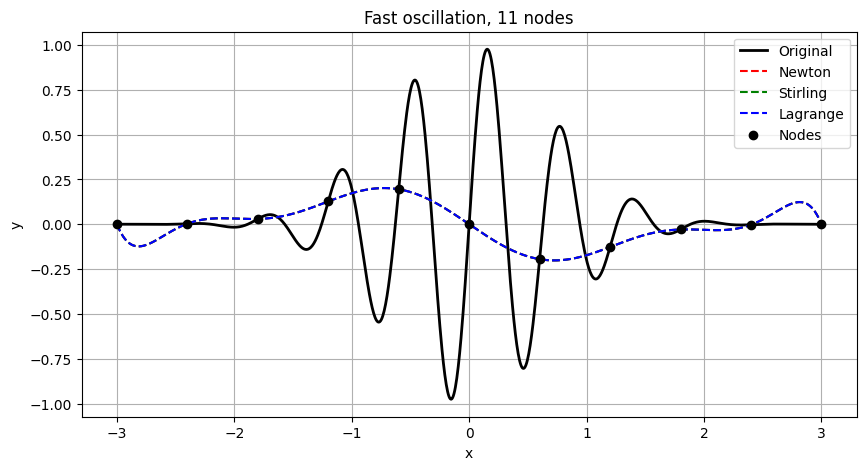

13 nodes: Newton error = 2.212e+00, Stirling error = 2.212e+00, Lagrange error = 2.212e+00


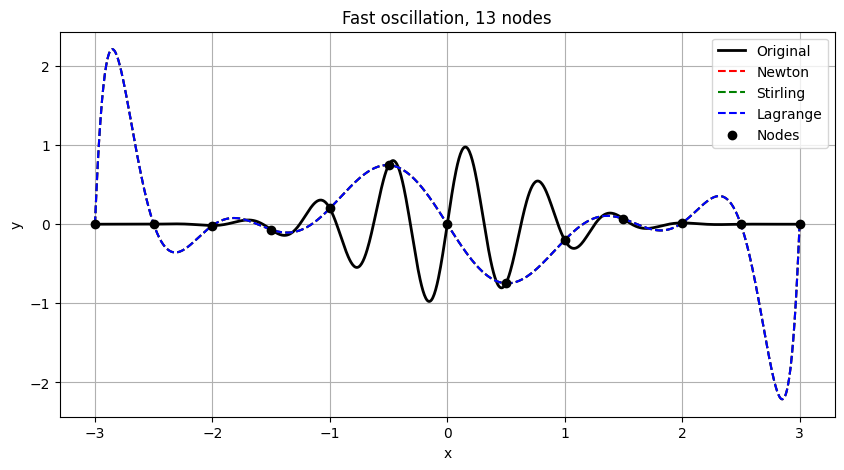

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, floor, exp


functions = [
    ('sin(x)', lambda x: np.sin(x), [0, 4*np.pi]),
    ('cos(x)', lambda x: np.cos(x), [0, 4*np.pi]),
    ('Runge', lambda x: 1/(1 + 25*x**2), [-1, 1]),
    ('Sawtooth', lambda x: x - 5*np.floor(x/5), [0, 20]),
    ('Fast oscillation', lambda x: np.sin(10*x) * np.exp(-x**2), [-3, 3])
]

node_numbers = [5, 7, 9, 11, 13]  


for name, func, interval in functions:
    print(f"\n=== Function: {name} ===")
    x_test = np.linspace(interval[0], interval[1], 1000) 
    
    for n in node_numbers:
        if n % 2 == 0:
            n += 1
        
        x_nodes = np.linspace(interval[0], interval[1], n)
        y_nodes = func(x_nodes)
        nodes = list(zip(x_nodes, y_nodes))
        
        newton_poly = NewtonPolynomial([type('Node', (), {'x': x, 'y': y}) for x, y in nodes])
        stirling_poly = StirlingPolynomial([type('Node', (), {'x': x, 'y': y}) for x, y in nodes])
        lagrange_poly = LagrangePolynomial(nodes)
        
        results = {}
        for poly_name, poly in [('Newton', newton_poly), ('Stirling', stirling_poly), ('Lagrange', lagrange_poly)]:
            y_pred = np.array([poly.evaluate(x) for x in x_test])   
            error = np.max(np.abs(func(x_test) - y_pred))
            results[poly_name] = error
        print(f"{n} nodes: " + ", ".join([f"{k} error = {v:.3e}" for k,v in results.items()]))
        
        y_newton = np.array([newton_poly.evaluate(x) for x in x_test])
        y_stirling = np.array([stirling_poly.evaluate(x) for x in x_test])
        y_lagrange = np.array([lagrange_poly.evaluate(x) for x in x_test])
        
        plt.figure(figsize=(10,5))
        plt.plot(x_test, func(x_test), 'k', label='Original', linewidth=2)
        plt.plot(x_test, y_newton, '--r', label='Newton')
        plt.plot(x_test, y_stirling, '--g', label='Stirling')
        plt.plot(x_test, y_lagrange, '--b', label='Lagrange')
        plt.scatter(x_nodes, y_nodes, color='black', zorder=5, label='Nodes')
        plt.title(f"{name}, {n} nodes")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.grid(True)
        plt.show()



### 3. Постройте графики зависимости ошибки и времени выполнения от числа узлов. Сделайте выводы


### 3. Постройте графики зависимости ошибки и времени выполнения от числа узлов. Сделайте выводы

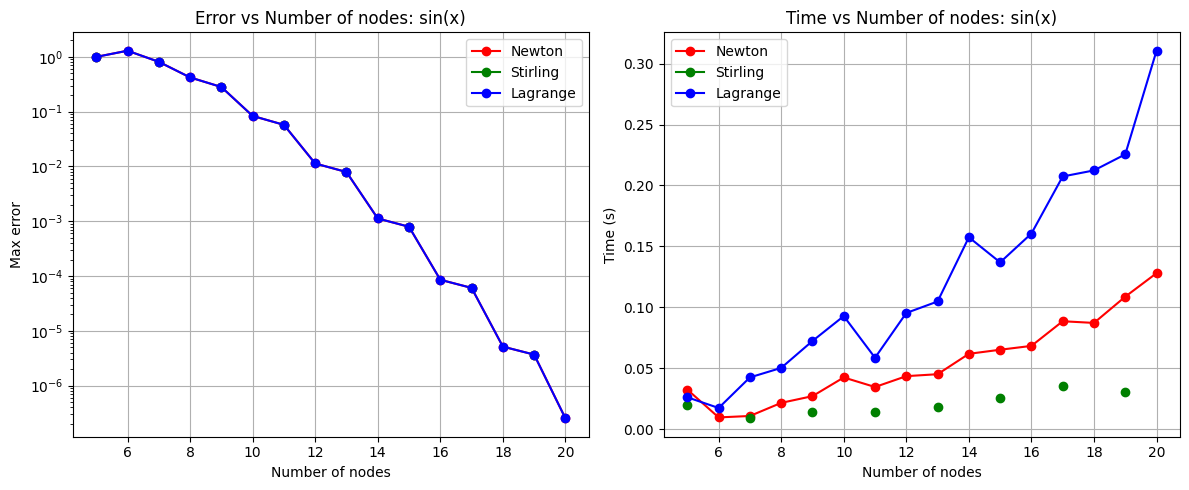

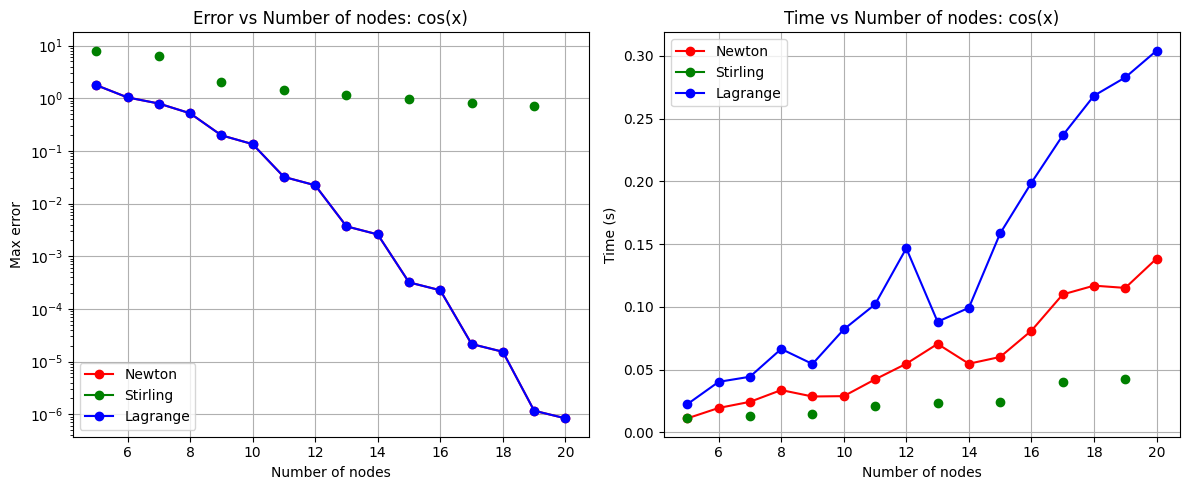

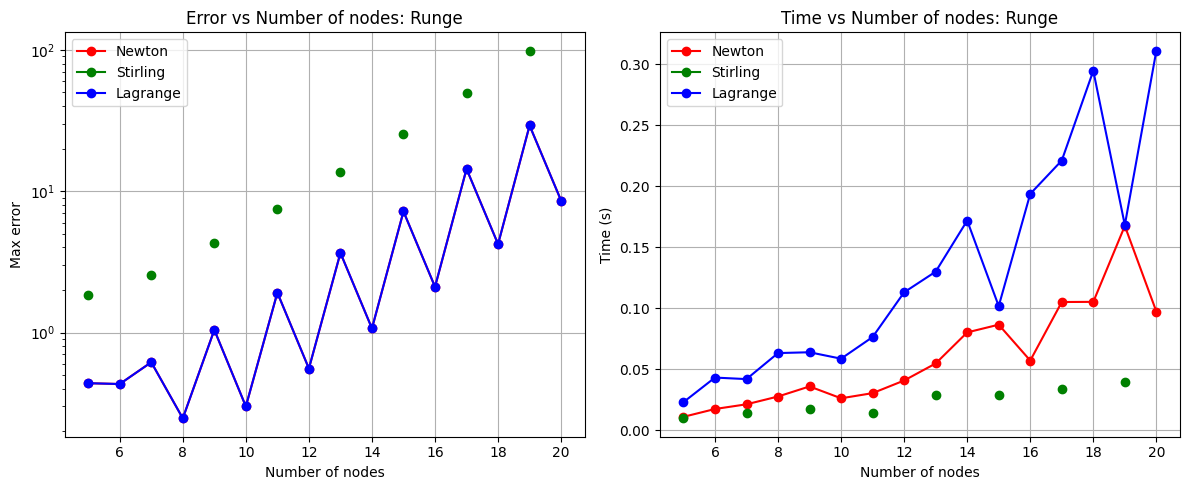

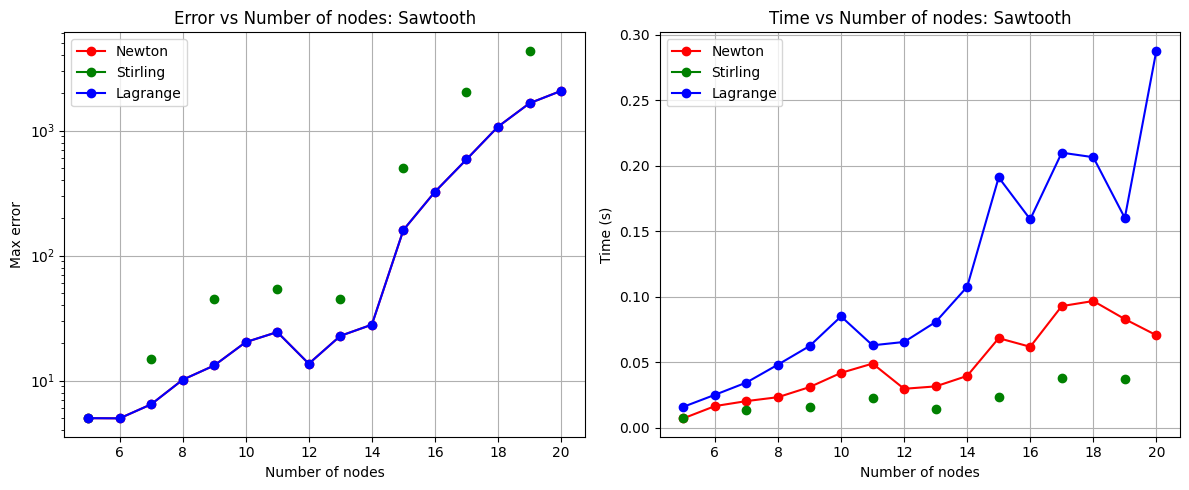

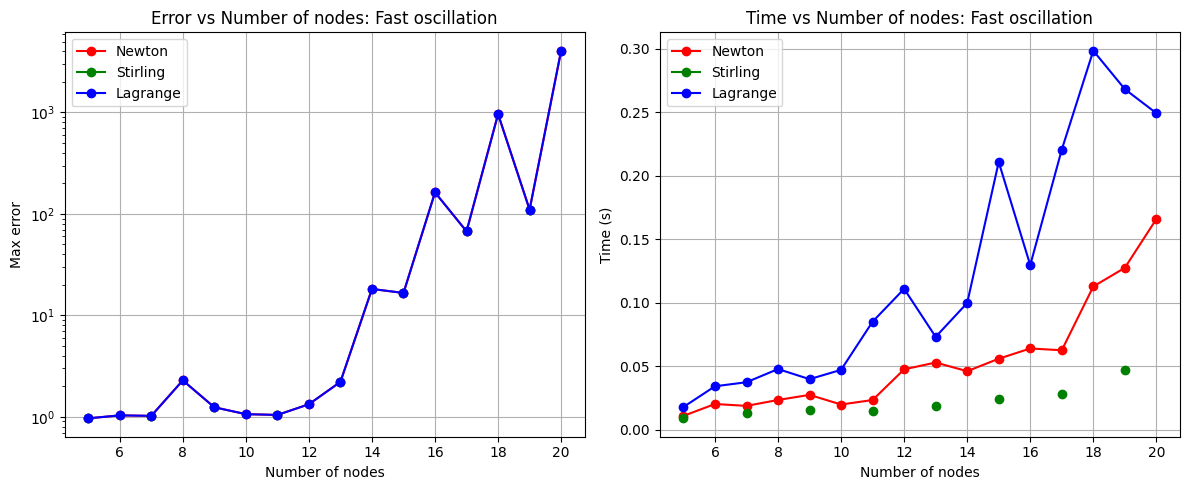

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import time
from math import sin, cos, floor, exp


functions = [
    ('sin(x)', lambda x: np.sin(x), [0, 4*np.pi]),
    ('cos(x)', lambda x: np.cos(x), [0, 4*np.pi]),
    ('Runge', lambda x: 1/(1 + 25*x**2), [-1, 1]),
    ('Sawtooth', lambda x: x - 5*np.floor(x/5), [0, 20]),
    ('Fast oscillation', lambda x: np.sin(10*x) * np.exp(-x**2), [-3, 3])
]

node_numbers = list(range(5, 21)) 
x_points = 1000 

for name, func, interval in functions:
    errors_newton, errors_stirling, errors_lagrange = [], [], []
    times_newton, times_stirling, times_lagrange = [], [], []
    
    x_test = np.linspace(interval[0], interval[1], x_points)
    
    for n in node_numbers:
        stirling_n = n if n % 2 == 1 else n+1
        
        x_nodes = np.linspace(interval[0], interval[1], n)
        y_nodes = func(x_nodes)
        nodes = list(zip(x_nodes, y_nodes))
        
        newton_poly = NewtonPolynomial([type('Node', (), {'x': x, 'y': y}) for x, y in nodes])
        start = time.time()
        y_pred = np.array([newton_poly.evaluate(x) for x in x_test])
        end = time.time()
        errors_newton.append(np.max(np.abs(func(x_test) - y_pred)))
        times_newton.append(end - start)
        
        if stirling_n <= len(x_nodes):  
            stirling_nodes = list(zip(np.linspace(interval[0], interval[1], stirling_n),
                                      func(np.linspace(interval[0], interval[1], stirling_n))))
            stirling_poly = StirlingPolynomial([type('Node', (), {'x': x, 'y': y}) for x, y in stirling_nodes])
            start = time.time()
            y_pred = np.array([stirling_poly.evaluate(x) for x in x_test])
            end = time.time()
            errors_stirling.append(np.max(np.abs(func(x_test) - y_pred)))
            times_stirling.append(end - start)
        else:
            errors_stirling.append(None)
            times_stirling.append(None)
        
        lagrange_poly = LagrangePolynomial(nodes)
        start = time.time()
        y_pred = np.array([lagrange_poly.evaluate(x) for x in x_test])
        end = time.time()
        errors_lagrange.append(np.max(np.abs(func(x_test) - y_pred)))
        times_lagrange.append(end - start)
    

    plt.figure(figsize=(12,5))
    

    plt.subplot(1,2,1)
    plt.plot(node_numbers, errors_newton, 'r-o', label='Newton')
    plt.plot(node_numbers, errors_stirling, 'g-o', label='Stirling')
    plt.plot(node_numbers, errors_lagrange, 'b-o', label='Lagrange')
    plt.yscale('log')
    plt.xlabel('Number of nodes')
    plt.ylabel('Max error')
    plt.title(f'Error vs Number of nodes: {name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(node_numbers, times_newton, 'r-o', label='Newton')
    plt.plot(node_numbers, times_stirling, 'g-o', label='Stirling')
    plt.plot(node_numbers, times_lagrange, 'b-o', label='Lagrange')
    plt.xlabel('Number of nodes')
    plt.ylabel('Time (s)')
    plt.title(f'Time vs Number of nodes: {name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
